# **Semantic Segmentation with UW-Madison GI Tract Dataset**

In this notebook, the [SegFormer-B3](https://huggingface.co/nvidia/mit-b3) model is fine-tuned using the [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/) dataset for semantic segmentation task.  

The [SegFormer](https://arxiv.org/pdf/2105.15203) model is an innovative approach to segmentation that balances efficiency and accuracy. It consists of two main components:  
1. **Hierarchical Transformer Encoder (MiT - Mix Transformer):** This encoder features a hierarchical design that effectively captures both global and local information from images. It has been pretrained on the [ImageNet-1k](https://www.image-net.org/download.php) dataset, providing robust visual feature representations.  

2. **Lightweight MLP-based Decoder Head:** This decoder head is designed to efficiently translate the features extracted by the encoder into detailed segmentation maps. However, for the specific *nvidia/mit-b3* model, the decoder has not been pretrained, requiring fine-tuning with a specific dataset for semantic segmentation tasks.

*SegFormer Model Architecture:*

![SegFormer](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/segformer_architecture.png)

The [UW-Madison GI Tract Image Segmentation](https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/) dataset was introduced in 2022 on the [Kaggle](https://www.kaggle.com/) platform as part of a medical image segmentation challenge. This dataset contains grayscale medical images of the gastrointestinal tract, specifically focusing on the **stomach**, **large bowel**, and **small bowel**.  

The publicly available dataset includes **16,590** images along with their corresponding segmentation masks. However, the test set is not publicly accessible. Therefore, the available dataset is typically randomly split into **80% (13,272 images) for training** and **20% (3,318 images) for validation**. 

## **Imports**

In [1]:
# Install the latest version of the Transformers library that is compatible with Colab's TPU
!pip install transformers==4.44.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 87.9 MB/s eta 0:00:00


In [ ]:
#!pip install tensorflow==2.17.0 -q #(TPU version)

In [2]:
import tensorflow as tf
from transformers import AutoImageProcessor, TFAutoModelForSemanticSegmentation, create_optimizer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from google.colab import drive
from tqdm.auto import tqdm
import cv2
import os

# Suppress AutoGraph warnings caused by the Transformers library
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(0)

In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## **Parameters**

In [4]:
model_name = "nvidia/mit-b3"
zip_dataset_path = "/content/drive/MyDrive/Datasets/UW-Madison-GI-Tract.zip"
dataset_dir = os.path.splitext(os.path.basename(zip_dataset_path))[0]
checkpoint_folder = "/content/drive/MyDrive/checkpoints/SemanticSegmentation_SegFormer-B3_UW-Madison-GI-Tract"
trained_model_path = "/content/drive/MyDrive/models/SemanticSegmentation_SegFormer-B3_UW-Madison-GI-Tract"
epochs = 100
batch_size = 32
patience = 7
save_freq = 25
SEED = 123
AUTOTUNE = tf.data.AUTOTUNE
buffer_size = 1024

## **Prepare the Dataset for Training**

### **Load the Dataset**

The download and all preliminary preprocessing of the **UW-Madison GI Tract** dataset were completed in the following notebook: [Preprocessing_UW-Madison-GI-Tract](https://github.com/JersonGB22/ImageSegmentation-TensorFlow-PyTorch/blob/main/Preprocessing/Preprocessing_UW-Madison-GI-Tract.ipynb).

In [5]:
# Unzip the dataset
!unzip -q $zip_dataset_path

In [6]:
# Get the training, validation, and test DataFrames
df_data = pd.read_csv(os.path.join(dataset_dir, "metadata.csv"))
df_train = df_data[df_data.split == "train"]
df_val = df_data[df_data.split == "val"]

print(len(df_train), len(df_val))
df_data

13272 3318


,image_path,mask_path,split
0,/content/UW-Madison-GI-Tract/images/case149_da...,/content/UW-Madison-GI-Tract/masks/case149_day...,train
1,/content/UW-Madison-GI-Tract/images/case43_day...,/content/UW-Madison-GI-Tract/masks/case43_day2...,train
2,/content/UW-Madison-GI-Tract/images/case9_day2...,/content/UW-Madison-GI-Tract/masks/case9_day20...,train
3,/content/UW-Madison-GI-Tract/images/case54_day...,/content/UW-Madison-GI-Tract/masks/case54_day3...,train
4,/content/UW-Madison-GI-Tract/images/case125_da...,/content/UW-Madison-GI-Tract/masks/case125_day...,train
...,...,...,...
16585,/content/UW-Madison-GI-Tract/images/case88_day...,/content/UW-Madison-GI-Tract/masks/case88_day0...,val
16586,/content/UW-Madison-GI-Tract/images/case136_da...,/content/UW-Madison-GI-Tract/masks/case136_day...,val
16587,/content/UW-Madison-GI-Tract/images/case30_day...,/content/UW-Madison-GI-Tract/masks/case30_day1...,val
16588,/content/UW-Madison-GI-Tract/images/case19_day...,/content/UW-Madison-GI-Tract/masks/case19_day1...,val


In [7]:
# Load the classes DataFrame
df_classes = pd.read_csv(os.path.join(dataset_dir, "classes.csv"))
df_classes["color"] = df_classes.color.apply(lambda x: eval(x))

class_names = df_classes.name.values.tolist()
class_colors = np.array(df_classes.color.values.tolist())
num_classes = len(class_names)
background_class = class_names.index("background")

df_classes

,name,color
0,background,"[0, 0, 0]"
1,stomach,"[255, 0, 0]"
2,large bowel,"[0, 255, 0]"
3,small bowel,"[0, 0, 255]"


### **Data Augmentation**

Data augmentation is crucial for improving a model's performance and combating overfitting. However, unfortunately, TensorFlow does not provide specific functions or layers for data augmentation in semantic segmentation tasks, so they must be implemented manually.

In [9]:
# Download the image and mask processor for the segmentation model
image_processor = AutoImageProcessor.from_pretrained(model_name)
image_processor

SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SegformerImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 512,
    "width": 512
  }
}

Although the processor has a default size of **(512, 512, 3)** for images and segmentation masks, a size of **(320, 320, 3)** is used because the dataset images are small. This does not affect the model's performance and also speeds up the fine-tuning process. 

In [10]:
# Set image size, mean, and standard deviation for normalization
image_size = (320, 320, 3) #(image_processor.size["height"], image_processor.size["width"], 3)
image_mean = tf.constant(image_processor.image_mean)
image_std = tf.constant(image_processor.image_std)

In [11]:
# Function for performing random horizontal flipping of the image and its mask
@tf.function
def random_flip_left_right(image, mask, p=0.5):
  if tf.random.uniform(()) > (1 - p):
    image = tf.image.flip_left_right(image)
    mask = tf.image.flip_left_right(mask)
  return image, mask


# Function for applying random horizontal and vertical translation to the image and its mask
# Inspired by https://github.com/keras-team/keras/blob/v3.3.3/keras/src/layers/preprocessing/random_translation.py#L7-L251
@tf.function
def random_translation(image, mask, height_factor=0.1, width_factor=0.1, p=0.5):
  if tf.random.uniform(()) > (1 - p):
    shape = tf.shape(image)[:2]
    height, width = tf.cast(shape[0], tf.float32), tf.cast(shape[1], tf.float32)

    height_shift = tf.random.uniform((), -height_factor, height_factor) * height
    width_shift = tf.random.uniform((), -width_factor, width_factor) * width
    transformation = tf.cast([[1, 0, -width_shift, 0, 1, -height_shift, 0, 0]], tf.float32)

    image = tf.raw_ops.ImageProjectiveTransformV3(
        images=image[None, :],
        transforms=transformation,
        output_shape=shape,
        fill_value=0,
        interpolation="BILINEAR",
        fill_mode="CONSTANT"
    )[0]
    mask = tf.raw_ops.ImageProjectiveTransformV3(
        images=mask[None, :],
        transforms=transformation,
        output_shape=shape,
        fill_value=background_class,
        interpolation="NEAREST",
        fill_mode="CONSTANT"
    )[0]

  return image, mask


# Function for performing random rotation of the image and its mask
# Inspired by https://github.com/keras-team/keras/blob/v3.3.3/keras/src/layers/preprocessing/random_rotation.py#L9-L254
@tf.function
def random_rotation(image, mask, max_angle=15, p=0.5):
  if tf.random.uniform(()) > (1 - p):
    shape = tf.shape(image)[:2]
    height, width = tf.cast(shape[0], tf.float32), tf.cast(shape[1], tf.float32)

    max_angle *= tf.constant(np.pi) / 180
    angle = tf.random.uniform((), -max_angle, max_angle)

    sin_angle = tf.sin(angle)
    cos_angle = tf.cos(angle)
    x_offset = ((width - 1) - (cos_angle * (width - 1) - sin_angle * (height - 1))) / 2
    y_offset = ((height - 1) - (sin_angle * (width - 1) + cos_angle * (height - 1))) / 2

    transformation = tf.convert_to_tensor(
        [[cos_angle, -sin_angle, x_offset, sin_angle, cos_angle, y_offset, 0, 0]],
        dtype=tf.float32
    )

    image = tf.raw_ops.ImageProjectiveTransformV3(
        images=image[None, :],
        transforms=transformation,
        output_shape=shape,
        fill_value=0,
        interpolation="BILINEAR",
        fill_mode="CONSTANT"
    )[0]

    mask = tf.raw_ops.ImageProjectiveTransformV3(
        images=mask[None, :],
        transforms=transformation,
        output_shape=shape,
        fill_value=background_class,
        interpolation="NEAREST",
        fill_mode="CONSTANT"
    )[0]

  return image, mask


# Function for randomly altering the brightness and contrast of the image
@tf.function
def random_brightness_contrast(image, brightness_limit=0.2, contrast_limit=0.3, p=0.5):
  if tf.random.uniform(()) > (1 - p):
    image = tf.image.random_brightness(image, brightness_limit)
    image = tf.image.random_contrast(image, 1 - contrast_limit, 1 + contrast_limit)
  return image

In [12]:
# Function for data augmentation
def data_augmentation(image, mask):
  image, mask = random_flip_left_right(image, mask)
  image, mask = random_translation(image, mask)
  image, mask = random_rotation(image, mask)
  image = random_brightness_contrast(image, brightness_limit=0.15, contrast_limit=0.2)

  return image, mask

### **Create the Training and Validation Datasets**

In [13]:
# Function to preprocess an image and its mask
@tf.function
def preprocessing(image_path, mask_path, image_size=image_size[:-1]):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, channels=3)
  image = tf.image.resize(image, image_size)

  mask = tf.io.read_file(mask_path)
  mask = tf.image.decode_png(mask, channels=1)
  mask = tf.image.resize(mask, image_size, method="nearest")

  return image, mask


# Function to normalize image and mask
@tf.function
def normalization(image, mask):
  image = ((image / 255) - image_mean) / image_std
  image = tf.transpose(image, [2, 0, 1])
  mask = tf.squeeze(mask)
  return image, mask


# Function to convert the DataFrame into a Dataset for training or evaluation
def prepare_dataset(df, train=True, drop_remainder=True):
  dataset = tf.data.Dataset.from_tensor_slices((df["image_path"].values, df["mask_path"].values))
  dataset = dataset.map(preprocessing, num_parallel_calls=AUTOTUNE)

  if train:
    dataset = dataset.map(data_augmentation, num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(buffer_size, seed=SEED)

  dataset = (
      dataset.
      map(normalization, num_parallel_calls=AUTOTUNE).
      batch(batch_size, drop_remainder=drop_remainder).
      prefetch(AUTOTUNE)
  )

  return dataset

In the Google Colab TPU environment, when using custom loss functions to train a model, it is necessary for all batches to have the same size. Otherwise, the loss at the end of the first epoch will return a **NaN** value. Therefore, the `drop_remainder` parameter should be set to **True** to discard the last batch of a dataset. Additionally, it is important to choose a batch size that removes the least amount of data from the last batch to minimize the impact on training.  

On the other hand, during model evaluation, the complete dataset should be used with `drop_remainder` set to **False**. Although if a batch size is chosen that removes very few data, the evaluation results will vary slightly, being virtually the same, but it is a good practice to set `drop_remainder` to **False** during evaluation to obtain exact results.

In [ ]:
# Number of records deleted
len(df_train) % batch_size, len(df_val) % batch_size

(24, 22)

In [ ]:
train_dataset = prepare_dataset(df_train)
val_dataset = prepare_dataset(df_val, train=False)

In [ ]:
# Take a batch from the training dataset
for images, masks in train_dataset.take(1):
  print(images.shape)
  print(masks.shape)

(32, 3, 320, 320)
(32, 320, 320)


In [23]:
# Function to plot images with their segmentation masks
def plot_image_masks(images, masks, masks_pred=None, n_rows=3, random=True, blended=False,
                     alpha=0.4, metric=None, preprocess=False, save=False, path_save=""):

  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  n_cols = 2 if masks_pred is None else 3
  titles = ["Image", "True Mask"] + ([] if masks_pred is None else ["Pred Mask"])

  fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.25 * n_cols, 3.25 * n_rows))
  for col, title in enumerate(titles):
    axes[0, col].set_title(title, fontsize=10)

  for i in range(n_rows):
    idx = indices[i]
    image = tf.transpose(images[idx], [1, 2, 0])
    image = np.clip((image * image_std) + image_mean, 0, 1)
    mask_cls = masks[idx]
    mask_rgb = class_colors[mask_cls] / 255
    shape = image.shape

    if blended:
      mask_rgb = mask_rgb.astype(image.dtype)
      mask_rgb[mask_cls == background_class] = image[mask_cls == background_class]
      mask_rgb = cv2.addWeighted(image, 1 - alpha, mask_rgb, alpha, 0)

    axes[i, 0].imshow(image)
    axes[i, 0].axis("off")
    axes[i, 1].imshow(mask_rgb)
    axes[i, 1].axis("off")

    if masks_pred is not None:
      mask_cls_pred = masks_pred[idx]
      mask_rgb_pred = class_colors[mask_cls_pred] / 255

      if blended:
        mask_rgb_pred = mask_rgb_pred.astype(image.dtype)
        mask_rgb_pred[mask_cls_pred == background_class] = image[mask_cls_pred == background_class]
        mask_rgb_pred = cv2.addWeighted(image, 1 - alpha, mask_rgb_pred, alpha, 0)

      axes[i, 2].imshow(mask_rgb_pred)
      axes[i, 2].axis("off")

      if metric is not None:
        metric.reset_state()
        metric.update_state(mask_cls, mask_cls_pred, preprocess=preprocess)

        axes[i, 2].text(
          x=shape[1]/2, y=shape[0],
          s=f"{metric.metric_name.replace('_', ' ')}: {metric.result():.3f}",
          fontsize=7, ha="center", va="top",
        )

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path_save)

  plt.show()

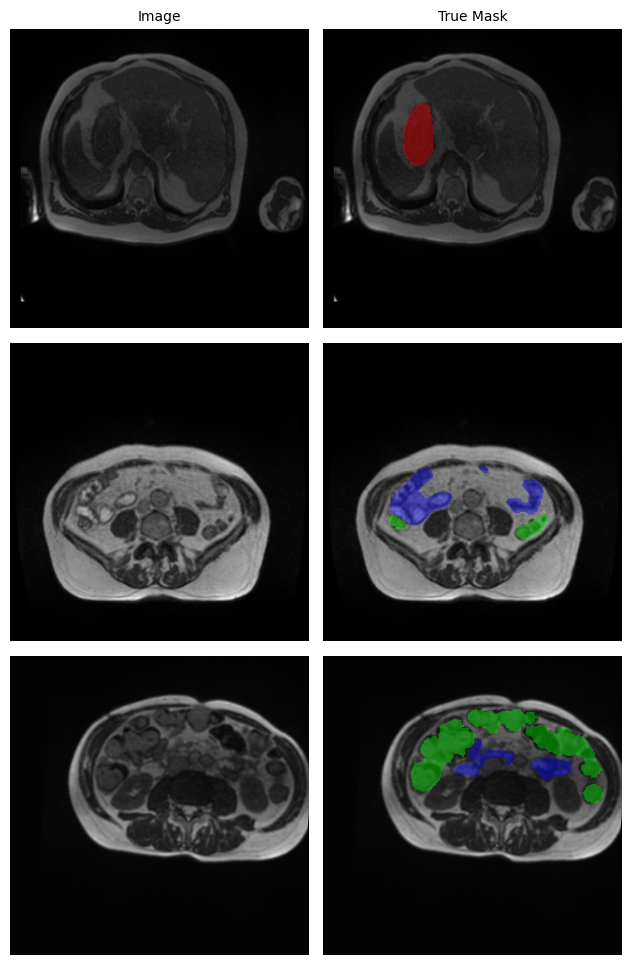

In [ ]:
# Some images and masks from the training dataset after data augmentation
plot_image_masks(images, masks, blended=True)

## **Build and Compile the Model**

### **Create the Segmentation Metrics and Loss**

In image semantic segmentation, the most commonly used metrics to evaluate model performance are **Mean IoU** and **Dice Score**.  

1. **Mean IoU:** Mean IoU (Intersection over Union) measures the overlap between the predicted areas and the ground truth areas for each class and averages the results across all classes. It is a standard metric in semantic segmentation. Its general formula for the multiclass case is:  
   $$
   Mean\ IoU = \frac{1}{C} \sum_{c=1}^C \frac{|P_c \cap T_c|}{|P_c \cup T_c|}
   $$
   Where:  
   - $C$ is the number of classes.  
   - $P_c$ and $T_c$ represent the predicted areas and the ground truth areas for class $c$.  
   - $|P_c \cap T_c|$ is the intersection area between the prediction and the ground truth.  
   - $|P_c \cup T_c|$ is the union area between the prediction and the ground truth.  

2. **Dice Score:** Dice Score (or Dice Coefficient) is another common metric that measures the similarity between predicted and true areas. It is particularly useful for imbalanced datasets. Its general formula for the multiclass case is:  
   $$
   Dice\ Score = \frac{1}{C} \sum_{c=1}^C \frac{2 |P_c \cap T_c|}{|P_c| + |T_c|}
   $$
   The terms are the same as in Mean IoU, but Dice Score is more sensitive to small differences between the prediction and the ground truth.  

A custom class implemented in TensorFlow is introduced below to calculate these metrics, designed to work for both binary and multiclass segmentation. Key features of this class include:  

- **Support for ignored classes:** Specific classes, such as the background or unlabeled regions, can be excluded from the metric calculations. An example of this case can be seen in the notebook [SemanticSegmentation_SegFormer-B2_CamVid](https://github.com/JersonGB22/ImageSegmentation-TensorFlow-PyTorch/blob/main/SemanticSegmentation/SemanticSegmentation_SegFormer-B2_CamVid.ipynb).

- **Handling absent classes:** If one or more classes are missing in the true and predicted masks, the metric returns a NaN value for those classes, ensuring they are excluded from the final calculation. This is particularly useful in multiclass segmentation, where individual masks or batches may not include all classes in a specific dataset, as is the case with *LandCover.ai* and *UW-Madison GI Tract*.

In [14]:
# Custom class to calculate Mean IoU or Dice Score
@tf.keras.utils.register_keras_serializable()
class SegmentationMetrics(tf.keras.metrics.Metric):
  def __init__(self, metric_name, num_classes, image_size, ignore_class=None, **kwargs):

    if metric_name not in {"mean_iou", "dice_score"}:
      raise ValueError("Invalid metric. Choose 'mean_iou' or 'dice_score'.")

    super().__init__(name=metric_name, **kwargs)
    self.metric_name = metric_name
    self.num_classes = num_classes
    self.image_size = image_size
    self.ignore_class = ignore_class

    # Initialize tensors to store cumulative intersection and combined areas
    self.intersect_area_total = self.add_weight(name="intersect_area", shape=(num_classes,), initializer="zeros")
    self.combined_area_total = self.add_weight(name="combined_area", shape=(num_classes,), initializer="zeros")

  def update_state(self, y_true, y_pred, preprocess=True, sample_weight=None):
    # Convert logits to class predictions if preprocessing is enabled
    if preprocess:
      y_pred = tf.transpose(y_pred, [0, 2, 3, 1])
      y_pred = tf.image.resize(y_pred, self.image_size[:-1])
      y_pred = tf.argmax(y_pred, axis=-1)

    # Flatten predictions and labels
    y_true = tf.reshape(tf.cast(y_true, tf.int32), (-1,))
    y_pred = tf.reshape(tf.cast(y_pred, tf.int32), (-1,))

    # Apply mask to ignore specific class, if configured
    if self.ignore_class is not None:
      mask = tf.not_equal(y_true, self.ignore_class)
      y_true = tf.boolean_mask(y_true, mask)
      y_pred = tf.boolean_mask(y_pred, mask)

    # Convert to one-hot encoding for multiclass processing
    y_true = tf.one_hot(y_true, depth=self.num_classes)
    y_pred = tf.one_hot(y_pred, depth=self.num_classes)

    # Calculate intersection and combined areas
    intersect_area = tf.reduce_sum(y_true * y_pred, axis=0)
    combined_area = tf.reduce_sum(y_true + y_pred, axis=0)

    # Update cumulative totals
    self.intersect_area_total.assign_add(intersect_area)
    self.combined_area_total.assign_add(combined_area)

  # Compute metric for each class
  def result_by_class(self):
    if self.metric_name == "mean_iou":
      union_area_total = self.combined_area_total - self.intersect_area_total
      metric = tf.math.divide_no_nan(self.intersect_area_total, union_area_total)
    else:
      metric = tf.math.divide_no_nan(2 * self.intersect_area_total, self.combined_area_total)

    # Assign NaN to classes with no samples
    metric = tf.where(self.combined_area_total > 0, metric, tf.constant(float("nan"), dtype=metric.dtype))
    return metric

  # Calculate average metric across valid classes
  def result(self):
    metric = self.result_by_class()
    metric = tf.boolean_mask(metric, tf.logical_not(tf.math.is_nan(metric)))
    return tf.reduce_mean(metric)

  # Reset accumulated values
  def reset_state(self):
    self.intersect_area_total.assign(tf.zeros_like(self.intersect_area_total))
    self.combined_area_total.assign(tf.zeros_like(self.combined_area_total))

  # Returns the configuration of the metric as a dictionary for serialization
  def get_config(self):
    return {
        "metric_name": self.metric_name,
        "num_classes": self.num_classes,
        "image_size": self.image_size,
        "ignore_class": self.ignore_class
    }


# Custom function to calculate Accuracy with the option to ignore a class
@tf.keras.utils.register_keras_serializable()
def compute_accuracy(image_size, ignore_class=None):
  def accuracy(y_true, y_pred):
    y_pred = tf.transpose(y_pred, [0, 2, 3, 1])
    y_pred = tf.image.resize(y_pred, image_size[:-1])
    y_pred = tf.cast(tf.argmax(y_pred, axis=-1), y_true.dtype)

    true_positives = tf.cast(y_true == y_pred, tf.float32)

    if ignore_class is not None:
      mask = tf.cast(y_true != ignore_class, tf.float32)
      acc = tf.reduce_sum(true_positives * mask) / tf.reduce_sum(mask)
    else:
      acc = tf.reduce_mean(true_positives)

    return acc
  return accuracy

  A custom loss class is implemented that combines **Cross-Entropy loss** and **Dice loss ($1 - Dice\ Score$)**. Cross-entropy measures pixel-level similarity between predicted and true masks, while Dice loss ensures precise boundary localization. This combination is effective for achieving both accurate localization and high overall precision in semantic segmentation. Additionally, the custom loss allows for ignoring specific classes, which is useful when discarding classes like **background** or **unlabeled** in specific datasets. It also supports cases where not all classes from a dataset may be present in a segmentation mask batch, as in the case of **UW-Madison GI Tract**.

In [ ]:
@tf.keras.utils.register_keras_serializable()
class CrossEntropyDiceLoss(tf.keras.losses.Loss):
  def __init__(self, num_classes, image_size, ignore_class=None, from_logits=False, name="crossentropy_dice_loss"):
    super().__init__(name=name)
    self.num_classes = num_classes
    self.image_size = image_size
    self.ignore_class = ignore_class
    self.from_logits = from_logits
    self.name = name
    self.scce_fn = tf.keras.losses.SparseCategoricalCrossentropy(reduction="none")

  def compute_dice_loss(self, y_true, y_pred):
    # Convert ground truth to one-hot encoding
    y_true_ohe = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)

    # Apply mask to ignore specific class, if configured
    if self.ignore_class is not None:
      mask = tf.cast(y_true != self.ignore_class, tf.float32)[..., None]
      y_true_ohe *= mask
      y_pred *= mask

    # Calculate the areas and Dice loss
    intersect_area = tf.reduce_sum(y_true_ohe * y_pred, axis=[0, 1, 2])
    combined_area = tf.reduce_sum(y_true_ohe + y_pred, axis=[0, 1, 2])
    loss = 1 - tf.math.divide_no_nan(2 * intersect_area, combined_area)

    # Discard the absent classes and calculate the average loss
    mask = tf.reduce_sum(y_true_ohe, axis=[0, 1, 2]) > 0
    loss = tf.boolean_mask(loss, mask)
    loss = tf.reduce_mean(loss)

    return loss

  def call(self, y_true, y_pred):
    # Preprocess the predicted masks
    y_pred = tf.transpose(y_pred, [0, 2, 3, 1])
    y_pred = tf.image.resize(y_pred, self.image_size[:-1])

    # Apply softmax to predicted logits, if configured
    if self.from_logits:
      y_pred = tf.nn.softmax(y_pred, axis=-1)

    # Calculate the Cross-Entropy loss
    scce_loss = self.scce_fn(y_true, y_pred)

    # Apply mask to ignore specific class, if configured, and calculate the average Cross-Entropy loss
    if self.ignore_class is not None:
      mask = tf.cast(y_true != self.ignore_class, tf.float32)
      scce_loss = tf.reduce_sum(scce_loss * mask) / tf.reduce_sum(mask)
    else:
      scce_loss = tf.reduce_mean(scce_loss)

    # Calculate the Dice loss
    dice_loss = self.compute_dice_loss(y_true, y_pred)

    # Calculate the overall loss
    loss = scce_loss + dice_loss
    return loss

  # Returns the configuration of the loss as a dictionary for serialization
  def get_config(self):
    return {
        "num_classes": self.num_classes,
        "image_size": self.image_size,
        "ignore_class": self.ignore_class,
        "from_logits": self.from_logits,
        "name": self.name
    }

### **TPU Initialization and Model Compilation**

In [15]:
# TPU setup
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu="local")
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
  print("TPU initialized:")
  print("All devices: ", tf.config.list_logical_devices("TPU"))
except (ValueError, tf.errors.InvalidArgumentError, tf.errors.NotFoundError) as error:
  print(f"Error: {error}")

TPU initialized:
All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [ ]:
# Compile the model within the TPU strategy
tf.keras.backend.clear_session()

with strategy.scope():
  model = TFAutoModelForSemanticSegmentation.from_pretrained(
      model_name,
      num_labels=num_classes
  )

  optimizer, lr_schedule = create_optimizer(
      init_lr=5e-4,
      num_train_steps=len(train_dataset)*epochs,
      num_warmup_steps=0,
      min_lr_ratio=1e-3,  #end_lr = init_lr * min_lr_ratio
      weight_decay_rate=0.01
  )

  model.compile(
      optimizer=optimizer,
      loss=CrossEntropyDiceLoss(num_classes, image_size, from_logits=True),
      metrics=[
          compute_accuracy(image_size),
          SegmentationMetrics("mean_iou", num_classes, image_size)
      ],
      steps_per_execution=50
  )

model.summary()

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

tf_model.h5:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some layers from the model checkpoint at nvidia/mit-b3 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  44072128  
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  3154948   
 codeHead)                                                       
                                                                 
Total params: 47227076 (180.16 MB)
Trainable params: 47225540 (180.15 MB)
Non-trainable params: 1536 (6.00 KB)
_________________________________________________________________


## **Train the Model**

Since the free version of Google Colab has a TPU environment limit of 3 hours and 20 minutes, a custom callback is implemented to save the model, its optimizer, and the training history, which includes the training and validation metrics and losses throughout the epochs. This allows for resuming the training from where it was left off. The total fine-tuning time for the model is approximately **5 hours**.

In [ ]:
# Callback to save checkpoints and training history
class CheckpointCallback(tf.keras.callbacks.Callback):
  def __init__(self, checkpoint, path_save, save_freq, history):
    super().__init__()
    self.checkpoint = checkpoint
    self.path_save = path_save
    self.save_freq = save_freq
    self.history = history

  def on_epoch_end(self, epoch, logs=None):
    epoch_history = pd.DataFrame({k: [v] for k, v in logs.items()})
    self.history = pd.concat([self.history, epoch_history], axis=0, ignore_index=True)
    self.history.to_csv(os.path.join(self.path_save, "history.csv"), index=False)

    if (epoch + 1) % self.save_freq == 0:
      self.checkpoint.save(file_prefix=os.path.join(self.path_save, f"epoch_{epoch + 1}"))

In [ ]:
checkpoint = tf.train.Checkpoint(model=model, optimizer=optimizer)
pretrained = True #Change according to previous training

if pretrained:
  checkpoint.restore(tf.train.latest_checkpoint(checkpoint_folder))
  history = pd.read_csv(os.path.join(checkpoint_folder, "history.csv"))
  initial_epoch = len(history)

else:
  os.makedirs(checkpoint_folder, exist_ok=True)
  history = pd.DataFrame({
      "loss": [], "val_loss": [],
      "accuracy": [], "val_accuracy": [],
      "mean_iou": [], "val_mean_iou": []
  })
  initial_epoch = 0

In [ ]:
# Instantiate the checkpoint callback
checkpoint_callback = CheckpointCallback(checkpoint, checkpoint_folder, save_freq, history)

# Early stopping callback to monitor validation Mean IoU
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_mean_iou",
    patience=patience,
    mode="max",
    restore_best_weights=True
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint_callback, early_callback],
    initial_epoch=initial_epoch
)

Epoch 76/100
414/414 [==============================] - 479s 1s/step - loss: 0.0576 - accuracy: 0.9959 - mean_iou: 0.9274 - val_loss: 0.0887 - val_accuracy: 0.9942 - val_mean_iou: 0.8971
Epoch 77/100
414/414 [==============================] - 185s 447ms/step - loss: 0.0575 - accuracy: 0.9959 - mean_iou: 0.9276 - val_loss: 0.0877 - val_accuracy: 0.9942 - val_mean_iou: 0.8974
Epoch 78/100
414/414 [==============================] - 181s 437ms/step - loss: 0.0569 - accuracy: 0.9959 - mean_iou: 0.9282 - val_loss: 0.0877 - val_accuracy: 0.9943 - val_mean_iou: 0.8977
Epoch 79/100
414/414 [==============================] - 180s 434ms/step - loss: 0.0566 - accuracy: 0.9959 - mean_iou: 0.9287 - val_loss: 0.0881 - val_accuracy: 0.9943 - val_mean_iou: 0.8975
Epoch 80/100
414/414 [==============================] - 182s 440ms/step - loss: 0.0563 - accuracy: 0.9960 - mean_iou: 0.9291 - val_loss: 0.0876 - val_accuracy: 0.9943 - val_mean_iou: 0.8977
Epoch 81/100
414/414 [==============================]

In [ ]:
# Save the model
model.save_pretrained(trained_model_path)

## **Model Evaluation**

In [ ]:
# Evaluation excluding the last batches of the datasets (drop_remainder=True)
metrics_train = model.evaluate(train_dataset, verbose=0)
metrics_val = model.evaluate(val_dataset, verbose=0)

print(f"Train\tLoss: {metrics_train[0]}; Mean IoU: {metrics_train[2]}; Accuracy: {metrics_train[1]}")
print(f"Val\tLoss: {metrics_val[0]}; Mean IoU: {metrics_val[2]}; Accuracy: {metrics_val[1]}")

Train	Loss: 0.04714259132742882; Mean IoU: 0.9402267932891846; Accuracy: 0.9965928792953491
Val	Loss: 0.0877801775932312; Mean IoU: 0.9001903533935547; Accuracy: 0.9944123029708862


### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 14.5 MB/s eta 0:00:00


In [ ]:
# Load the training history
history = pd.read_csv(os.path.join(checkpoint_folder, "history.csv"))

# Delete the checkpoint if it is no longer needed
#!rm -r $checkpoint_folder

In [ ]:
# Function to plot the metrics
def plot_metrics(history, metrics=["loss"], renderer=None):
  epochs = len(history["loss"])
  list_epochs = np.arange(1, epochs + 1)
  patience = history.val_mean_iou.idxmax() + 1

  for metric in metrics:
    values = history[metric]
    val_values = history[f"val_{metric}"]

    fig=go.Figure()
    fig.add_trace(go.Scatter(x=list_epochs, y=values, name=metric, line=dict(color="blue", width=2)))
    fig.add_trace(go.Scatter(x=list_epochs, y=val_values, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

    fig.add_vline(
        x=patience, line=dict(color="red", width=2, dash="dash"),
        annotation_text="End of Training", annotation_position="top left",
        annotation=dict(font_size=12, font_color="red")
    )

    fig.update_xaxes(title_text="Epoch")
    fig.update_yaxes(title_text=metric)
    fig.update_layout(
        title=f"Evolution of {metric} across Epochs",
        title_font=dict(size=20),
        title_x=0.5,
        height=500,
        width=1200
    )

    fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics(history, metrics=["loss", "accuracy", "mean_iou"])

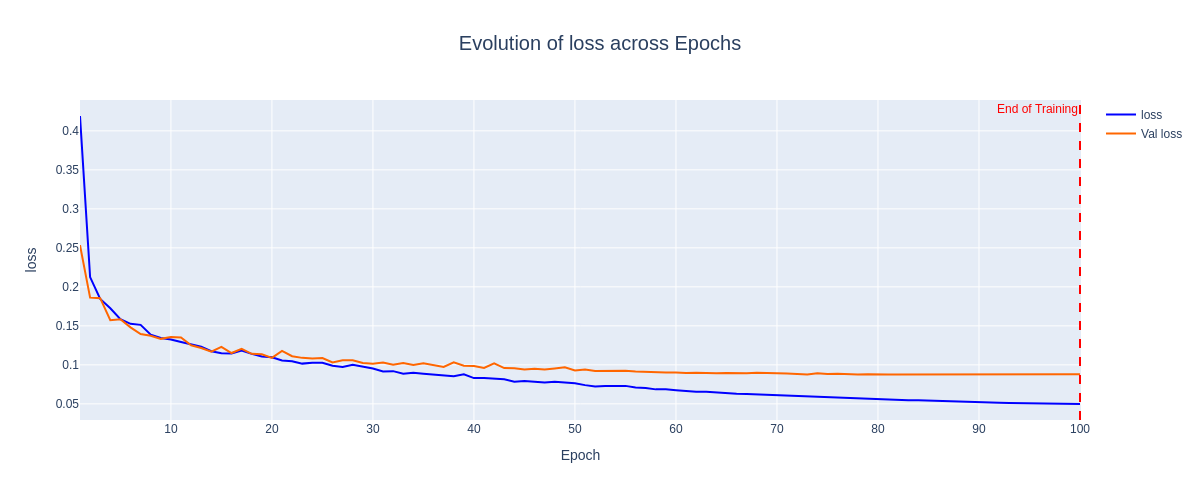

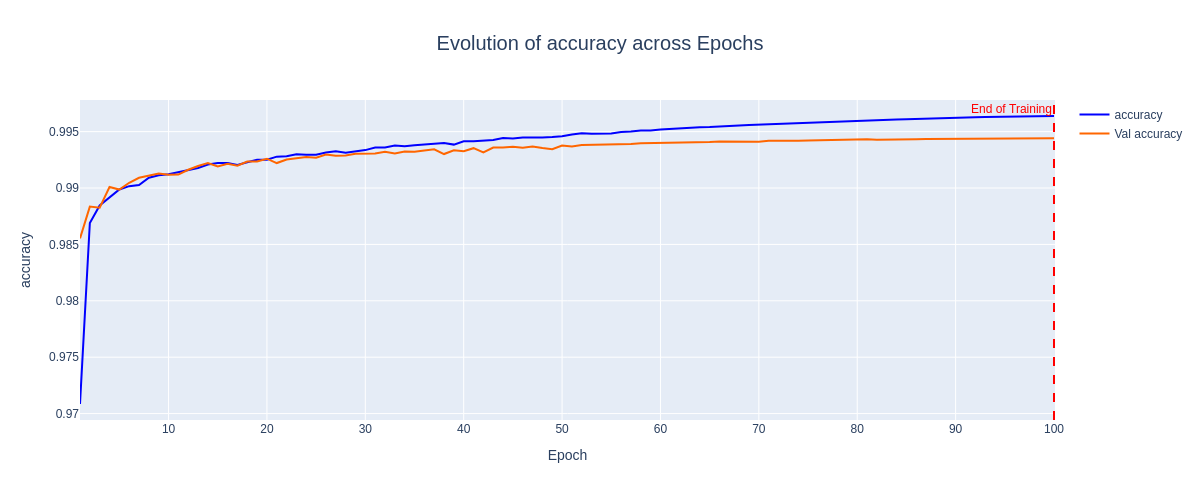

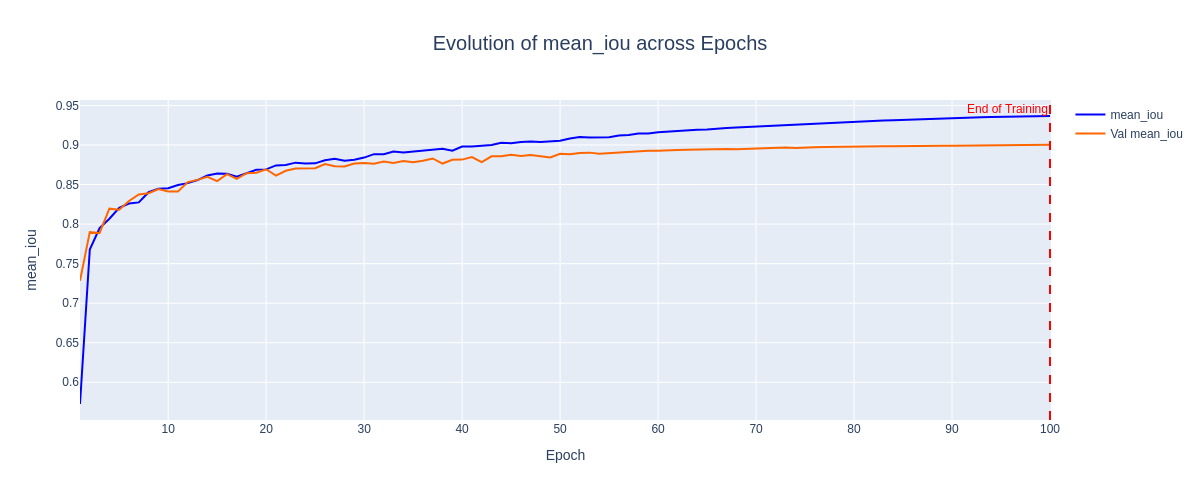

In [ ]:
# Static image for GitHub
plot_metrics(history, metrics=["loss", "accuracy", "mean_iou"], renderer="png")

### **Mean IoU and Dice Score**

In [16]:
# Load the fine-tuned model
tf.keras.backend.clear_session()

with strategy.scope():
  model = TFAutoModelForSemanticSegmentation.from_pretrained(trained_model_path)

All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

All the layers of TFSegformerForSemanticSegmentation were initialized from the model checkpoint at /content/drive/MyDrive/models/SemanticSegmentation_SegFormer-B3_UW-Madison-GI-Tract.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSegformerForSemanticSegmentation for predictions without further training.


In [17]:
# Instantiate the segmentation metrics
mean_iou = SegmentationMetrics(
    metric_name="mean_iou",
    num_classes=num_classes,
    image_size=image_size
)

dice_score = SegmentationMetrics(
    metric_name="dice_score",
    num_classes=num_classes,
    image_size=image_size
)

# TensorFlow Mean IoU Metric
mean_iou_tf = tf.keras.metrics.MeanIoU(
    num_classes=num_classes,
    sparse_y_true=True,
    sparse_y_pred=True
)

#### **Validation Dataset**

In [18]:
# Extract the components of the validation dataset and make predictions
val_dataset = prepare_dataset(
    df_val,
    train=False,
    drop_remainder=False
)

images_val = val_dataset.unbatch().map(lambda x, y: x)
images_val = np.array(list(images_val.as_numpy_iterator()))

masks_val = val_dataset.unbatch().map(lambda x, y: y)
masks_val = np.array(list(masks_val.as_numpy_iterator()))

masks_val_pred = model.predict(val_dataset).logits
masks_val_pred = tf.transpose(masks_val_pred, [0, 2, 3, 1])
masks_val_pred = tf.image.resize(masks_val_pred, image_size[:-1])
masks_val_pred = np.argmax(masks_val_pred, axis=-1)

104/104 [==============================] - 85s 415ms/step


In [19]:
# Update the metrics
for i in tqdm(range(0, len(masks_val), batch_size)):
  batch_true = masks_val[i: i + batch_size]
  batch_pred = masks_val_pred[i: i + batch_size]

  dice_score.update_state(batch_true, batch_pred, preprocess=False)
  mean_iou.update_state(batch_true, batch_pred, preprocess=False)
  mean_iou_tf.update_state(batch_true, batch_pred)

  0%|          | 0/104 [00:00<?, ?it/s]

In [20]:
# Create a DataFrame with the metrics for each class
df_val = pd.DataFrame({
    "Class": class_names,
    "IoU": mean_iou.result_by_class(),
    "Dice Score": dice_score.result_by_class()
})
df_val

,Class,IoU,Dice Score
0,background,0.994358,0.997171
1,stomach,0.896161,0.945237
2,large bowel,0.881312,0.936912
3,small bowel,0.828855,0.906419


In [21]:
df_val.IoU.mean(), mean_iou_tf.result().numpy(), df_val["Dice Score"].mean()

(0.9001714, 0.90017164, 0.946435)

It can be seen that the results of the custom **Mean IoU** metric and the **TensorFlow** metric match on both the training and test dataset, which helps verify and confirm that the custom metric is correctly implemented. However, the custom metric is superior as it not only calculates the **Mean IoU** but also the **Dice Score**. Additionally, it offers the option to calculate the **Mean IoU** both globally and per class, a feature that the **TensorFlow** metric does not provide.

## **Inference with the Trained Model**

### **Validation Dataset**

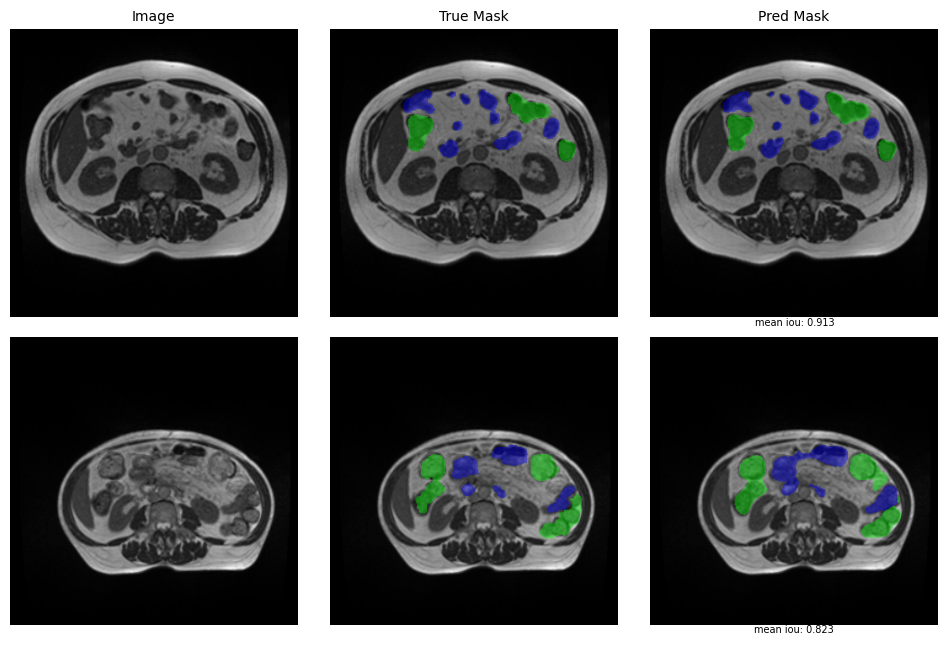

In [24]:
plot_image_masks(images_val, masks_val, masks_val_pred, n_rows=2, random=False, blended=True, metric=mean_iou)

The following example shows the results of the custom Mean IoU metric by class, highlighting the importance of not considering absent classes in the real and predicted segmentation masks. The average result matches TensorFlow's Mean IoU metric. Adding a very small epsilon value to both the numerator and denominator when calculating the Mean IoU or Dice Score to prevent division by zero could lead to incorrect results when classes are missing. If the real mask lacks certain classes and the model correctly predicts only the present classes, adding epsilon for absent classes would result in a value of 1 (perfect score), which would skew the average to an incorrect value. Similarly, adding a value of 0 for absent classes would also yield an incorrect and lower average. Therefore, it is important to assign a NaN value to absent classes in the real masks only if they are also absent in the predicted masks and to average the results only for classes with non-NaN values.

In [25]:
# Calculation of the Mean IoU for the first image in the above mosaic
id = 0
mean_iou.reset_state()
mean_iou_tf.reset_state()

mean_iou.update_state(masks_val[id], masks_val_pred[id], preprocess=False)
mean_iou_tf.update_state(masks_val[id], masks_val_pred[id])

print(pd.DataFrame({"class": class_names, "IoU": mean_iou.result_by_class()}), "\n")
print(mean_iou.result().numpy(), mean_iou_tf.result().numpy())

         class       IoU
0   background  0.993455
1      stomach       NaN
2  large bowel  0.908858
3  small bowel  0.835569 

0.9126274 0.9126274


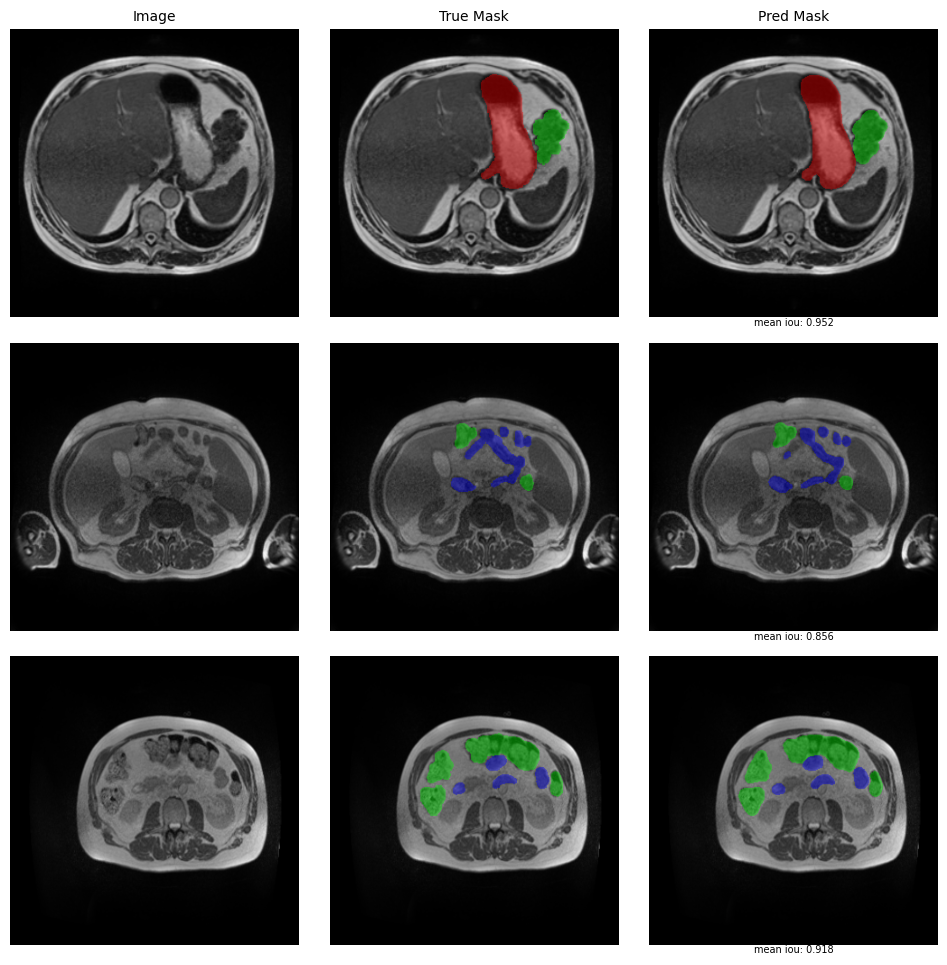

In [28]:
plot_image_masks(images_val, masks_val, masks_val_pred, blended=True, metric=mean_iou)

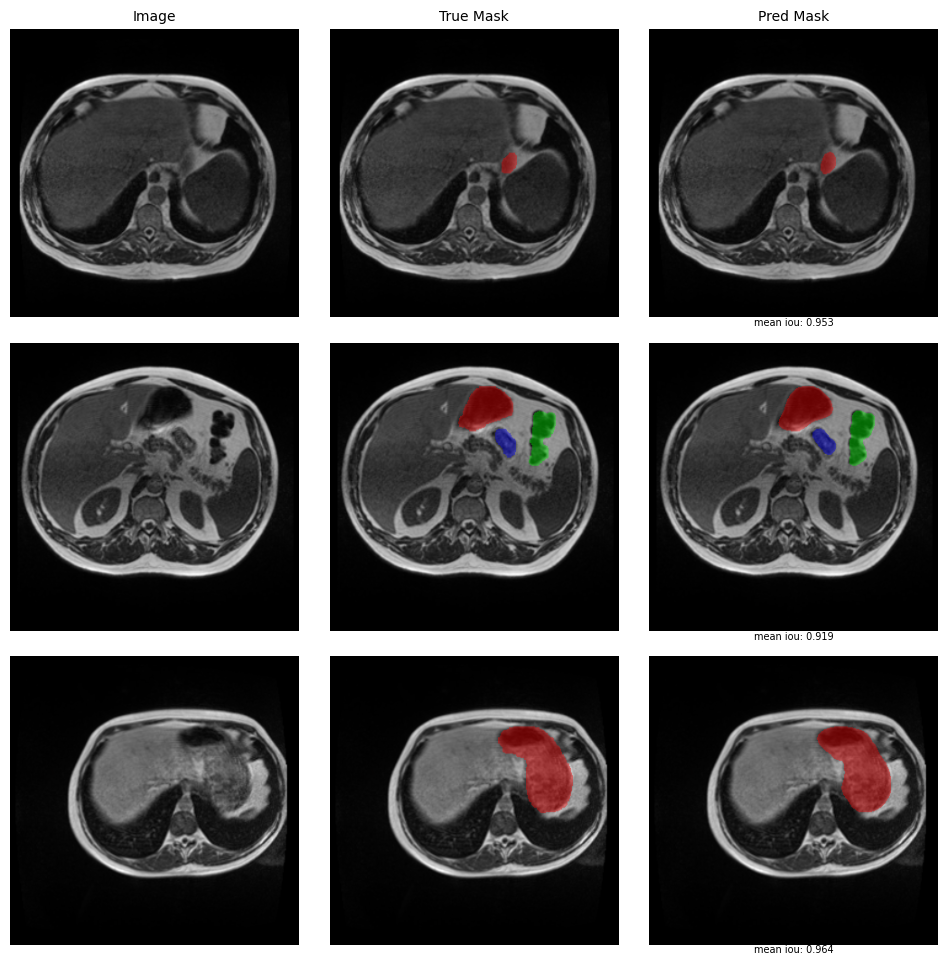

In [29]:
plot_image_masks(images_val, masks_val, masks_val_pred, blended=True, metric=mean_iou)

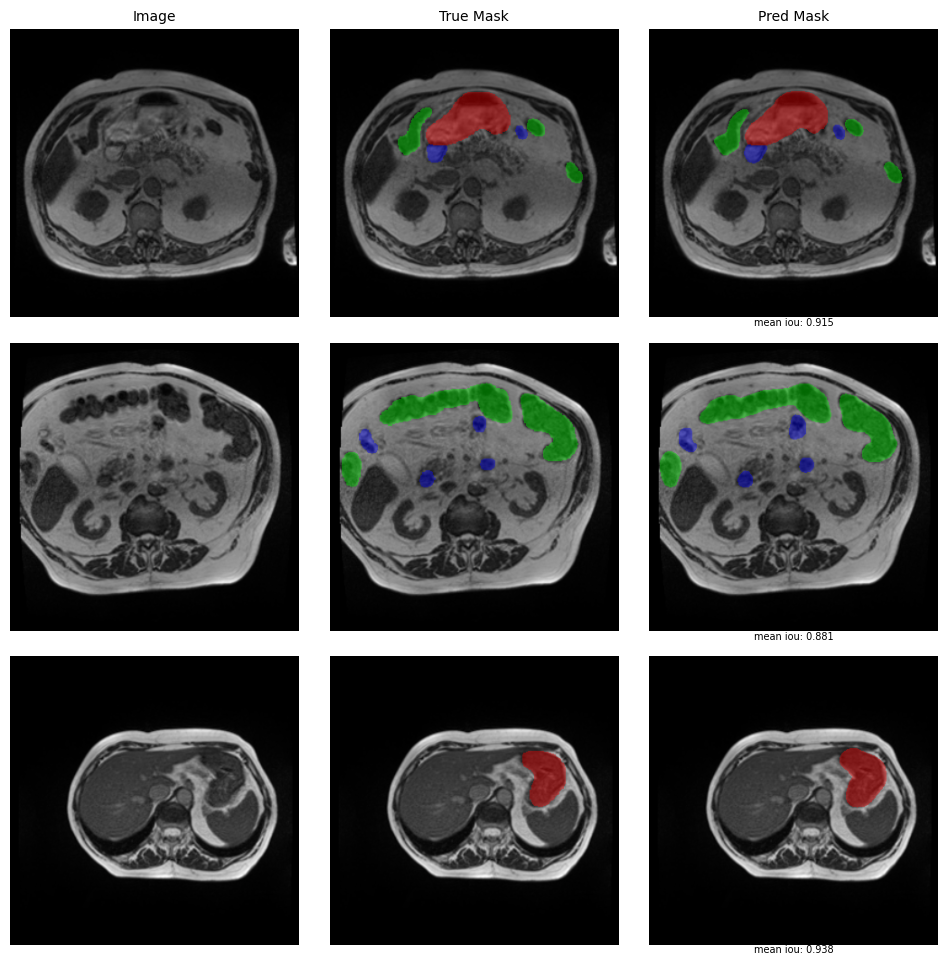

In [53]:
plot_image_masks(
    images_val, masks_val, masks_val_pred,
    blended=True, metric=mean_iou, save=True,
    path_save="SemanticSegmentation_SegFormer-B3_UW-Madison-GI-Tract.png"
)

## **Conclusion**

The **fine-tuned SegFormer-B3 model** has demonstrated exceptional performance in semantic segmentation of medical images in the **UW-Madison GI Tract Image Segmentation** dataset, achieving a **Mean IoU** of **0.9402** on the training dataset, a **Mean IoU** of **0.9002**, and a **Dice Score** of **0.9464** on the validation dataset.  

These results indicate a high level of performance in gastrointestinal tract segmentation. However, a slight overfitting is observed, along with lower accuracy in segmenting the **small bowel**, with a **Mean IoU slightly below 83%**. Despite this, the model generalizes well on the validation dataset. This suggests that the combination of **Dice Loss and Cross-Entropy Loss**, **data augmentation**, and the **optimizer from the Transformers library** effectively mitigated overfitting while achieving outstanding results.  

From the loss and segmentation metric graphs, it is observed that training the model beyond **100 epochs** could still yield slight improvements in the validation dataset and more significant improvements in the training dataset. However, this would increase overfitting, making further training not advisable.  

To achieve even better results, it would be beneficial to expand the training dataset with more images and segmentation masks, especially those with a higher representation of the **small bowel** class. Additionally, using larger models such as **SegFormer-B5** could be an option, but it would require greater computational capacity than Google Colab’s free TPU. Nevertheless, overall, the results obtained show that the model is highly effective for this medical segmentation task. 